# K-Nearest Neighbors

K-Nearest Neighbors is suitable for this type of classifications as it allows for high classification accuracy even with complex data distributions. Its capacity to support both binary and muti-class classification makes it a very good candidate for estimating room occupancy.


In [1]:
# Import libraries needed
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

## Data Setup

In [2]:
# Read dataset and create training an testing datasets
training_set = pd.read_csv('../Data/train.csv')
training_set = training_set.drop(columns=["id"])
training_set["defects"] = [1 if value else 0 for value in training_set["defects"]]
training_set = training_set.rename(columns={"v(g)": "v_g", "ev(g)": "ev_g", "iv(g)": "iv_g"})

In [3]:
true_data = training_set[training_set["defects"].values == True]
false_data = training_set[training_set["defects"].values == False]

true_feature_data = true_data.drop(columns=["defects"])
false_feature_data = false_data.drop(columns=["defects"])

true_train_proportion = 0.5
false_train_proportion = true_train_proportion * len(true_feature_data) / len(false_feature_data)

true_X_train, true_X_validation, true_Y_train, true_Y_validation = train_test_split(true_feature_data, true_data["defects"], test_size=(1-true_train_proportion))
false_X_train, false_X_validation, false_Y_train, false_Y_validation = train_test_split(false_feature_data, false_data["defects"], test_size=(1-false_train_proportion))

X_train = pd.concat([true_X_train, false_X_train])
X_validation = pd.concat([true_X_validation, false_X_validation])
Y_train = pd.concat([true_Y_train, false_Y_train])
Y_validation = pd.concat([true_Y_validation, false_Y_validation])

## Model Creation

In [4]:
class KNN:
    """
    Class to store data for regression problems 
    """
    def __init__(self, x_train, y_train, K=5):
        """
        Creates a kNN instance

        :param x_train: numpy array with shape (n_rows,1)- e.g. [[1,2],[3,4]]
        :param y_train: numpy array with shape (n_rows,)- e.g. [1,-1]
        :param K: The number of nearest points to consider in classification
        """
        
        # Import and build the BallTree on training features 
        from sklearn.neighbors import BallTree
        self.balltree = BallTree(x_train)
        
        # Cache training labels and parameter K 
        self.y_train = y_train
        self.K = K 
        
        
    def majority(self, neighbor_indices, neighbor_distances=None):
        """
        Given indices of nearest neighbors in training set, return the majority label. 
        Break ties by considering 1 fewer neighbor until a clear winner is found. 

        :param neighbor_indices: The indices of the K nearest neighbors in self.X_train 
        :param neighbor_distances: Corresponding distances from query point to K nearest neighbors. 
        """
        
        while(True):
            label_count = {}
            
            # Get label counts for all datapoint's neighbors
            for i in neighbor_indices:
                label = self.y_train[i]
                if label in label_count:
                    label_count[label] += 1
                else:
                    label_count[label] = 1
            
            # Get first class with highest count
            max_value = max(label_count.values())
            max_key = max(label_count, key=label_count.get)
            
            # Ensure there are no max-count ties
            n_modes = 0
            for x in label_count:
                if(x == max_value):
                    n_modes += 1
            
            # If a tie was detected, remove furthest neighbor and iterate again
            if(n_modes > 1):
                furthest_neighbor = neighbor_distances.index(max(neighbor_distances))
                del neighbor_indices[furthest_neighbor]
                del neighbor_distances[furthest_neighbor]
            else:
                # Otherwise, return class with highest neighbor count
                return max_key
            
        
    def classify(self, x):
        """
        Given a query point, return the predicted label 
        
        :param x: a query point stored as an ndarray  
        """

        # Get neighbors and their distances
        neighbor_distances, neighbor_indices = self.balltree.query(x.reshape(1, -1), k=self.K)

        # Get class with majority representation
        return self.majority(neighbor_indices[0], neighbor_distances[0])        
        
    def predict(self, X):
        """
        Given an ndarray of query points, an ndarray of predictions 

        :param X: an (m x p) dimension ndarray of points to predict labels for 
        """
        return [self.classify(item) for item in X]

## Model Evaluation

In [5]:
# Create a KNN classifier
knn = KNN(X_train.values, Y_train.values, K=3)

# Get prediction for testing dataset
prediction = knn.predict(X_validation.values)


In [6]:
conf_matrix = confusion_matrix(Y_validation.values, prediction, labels=[0, 1])

recall_true = conf_matrix[1][1] / (conf_matrix[1][0] + conf_matrix[1][1])
precision_true = conf_matrix[1][1] / (conf_matrix[0][1] + conf_matrix[1][1])
F1_true = 2 * ( (precision_true * recall_true) / (precision_true + recall_true) )

correct_vals = conf_matrix[0][0] + conf_matrix[1][1]
incorrect_vals = conf_matrix[0][1] + conf_matrix[1][0]
accuracy = correct_vals / (correct_vals + incorrect_vals)

print("Correctly predicted labelss: ", correct_vals)
print("Incorrectly predicted labelss: ", incorrect_vals)
print("Model's accuracy: ", accuracy)
print("Model's recall: ", recall_true)
print("Model's precision: ", precision_true)
print("Model's F1 score: ", F1_true)

Correctly predicted labelss:  52050
Incorrectly predicted labelss:  26649
Model's accuracy:  0.6613807036938207
Model's recall:  0.6560874089490114
Model's precision:  0.250123971040365
Model's F1 score:  0.3621741940116321


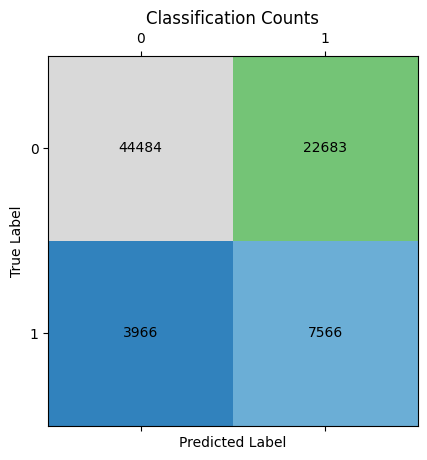

In [7]:
# Plot confusion Matrix
fig, ax = plt.subplots()
ax.matshow(conf_matrix, cmap='tab20c')

# Print classification counts within matrix boxes
for i in range(len(conf_matrix)):
   for j in range(len(conf_matrix[0])):
      c = conf_matrix[j, i]
      ax.text(i, j, str(c), va='center', ha='center')

# Set plot axis titles and show plot
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Classification Counts')
plt.show()

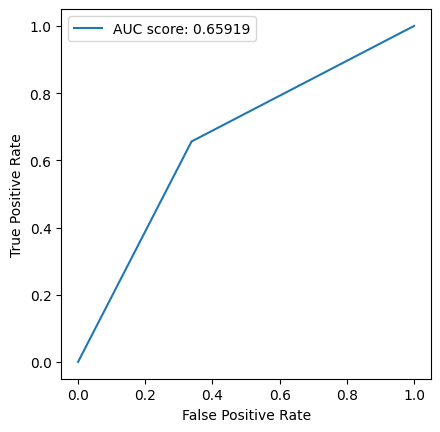

In [8]:
# Calculate scores for testing dataset
fpr, tpr, thresholds = roc_curve(Y_validation.values, prediction)

# Calculate AUC score
auc_score = roc_auc_score(Y_validation.values, prediction)

# Print ROC plot
plt.plot(fpr, tpr,)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(["AUC score: " + str(round(auc_score, 5))], loc="best")
plt.show()